In [ ]:
# !pip3 install xgboost

In [17]:
#import library
%matplotlib inline 
import matplotlib.pyplot as plt 

import numpy as np ; np.random.seed(sum(map(ord, "aesthetics")))
import pandas as pd

from sklearn.datasets import make_classification 
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import ShuffleSplit,train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler

import seaborn 
seaborn.set_context('notebook') 
seaborn.set_style(style='darkgrid')

#from pprint import pprint 
 

In [27]:
# Function for evaluation reports
def get_eval1(clf, X,y):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X, y, cv=2, scoring='accuracy')
    scores2 = cross_val_score(clf, X, y, cv=2, scoring='precision')
    scores3 = cross_val_score(clf, X, y, cv=2, scoring='recall')
    scores4 = cross_val_score(clf, X, y, cv=2, scoring='roc_auc')
    
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std()))
    
    return 

def get_eval2(clf, X_train, y_train,X_test, y_test):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X_test, y_test, cv=2, scoring='accuracy')
    scores2 = cross_val_score(clf, X_test, y_test, cv=2, scoring='precision')
    scores3 = cross_val_score(clf, X_test, y_test, cv=2, scoring='recall')
    scores4 = cross_val_score(clf, X_test, y_test, cv=2, scoring='roc_auc')
    
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std()))
    
    return  
  
# Function to get roc curve
def get_roc (y_test,y_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="upper left")
    plt.show()
    return

In [25]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import xgboost as xgb
from xgboost import XGBClassifier


# fit, train and cross validate Decision Tree with training and test data 
def xgbclf(params, X_train, y_train,X_test, y_test):
  
    eval_set=[(X_train, y_train), (X_test, y_test)]
    
    model = XGBClassifier(**params).\
      fit(X_train, y_train, eval_set=eval_set, \
                  eval_metric='auc', early_stopping_rounds = 100, verbose=100)
        
    #print(model.best_ntree_limit)

    model.set_params(**{'n_estimators': model.best_ntree_limit})
    model.fit(X_train, y_train)
    #print(model,'\n')
    
    # Predict target variables y for test data
    y_pred = model.predict(X_test, ntree_limit=model.best_ntree_limit) #model.best_iteration
    #print(y_pred)
   
    # Get Cross Validation and Confusion matrix
    #get_eval(model, X_train, y_train)
    #get_eval2(model, X_train, y_train,X_test, y_test)
    
    # Create and print confusion matrix    
    abclf_cm = confusion_matrix(y_test,y_pred)
    print(abclf_cm)
    
    #y_pred = model.predict(X_test)
    print (classification_report(y_test,y_pred) )
    print ('\n')
    print ("Model Final Generalization Accuracy: %.6f" %accuracy_score(y_test,y_pred) )
    
    # Predict probabilities target variables y for test data
    y_pred_proba = model.predict_proba(X_test, ntree_limit=model.best_ntree_limit)[:,1] #model.best_iteration
    get_roc (y_test,y_pred_proba)
    return model

def plot_featureImportance(model, keys):
    importances = model.feature_importances_
    importance_frame = pd.DataFrame({'Importance': list(importances), 'Feature': list(keys)})
    importance_frame.sort_values(by = 'Importance', inplace = True)
    importance_frame.tail(10).plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')

In [11]:
import pandas as pd
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)

file = "german.data"
names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']
data = pd.read_csv(file,names = names, delimiter=' ')

In [13]:
# Binarize the y output for easier use of e.g. ROC curves -> 0 = 'bad' credit; 1 = 'good' credit
data.classification.replace([1,2], [1,0], inplace=True)
# Print number of 'good' credits (should be 700) and 'bad credits (should be 300)
data.classification.value_counts()

1    700
0    300
Name: classification, dtype: int64

In [18]:
#numerical variables labels
numvars = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age', 
           'existingcredits', 'peopleliable', 'classification']

# Standardization
numdata_std = pd.DataFrame(StandardScaler().fit_transform(data[numvars].drop(['classification'], axis=1)))

In [19]:
from collections import defaultdict

#categorical variables labels
catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
           'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 
           'telephone', 'foreignworker']

d = defaultdict(LabelEncoder)

# Encoding the variable
lecatdata = data[catvars].apply(lambda x: d[x.name].fit_transform(x))

# print transformations
for x in range(len(catvars)):
    print(catvars[x],": ", data[catvars[x]].unique())
    print(catvars[x],": ", lecatdata[catvars[x]].unique())

#One hot encoding, create dummy variables for every category of every categorical variable
dummyvars = pd.get_dummies(data[catvars])

existingchecking :  ['A11' 'A12' 'A14' 'A13']
existingchecking :  [0 1 3 2]
credithistory :  ['A34' 'A32' 'A33' 'A30' 'A31']
credithistory :  [4 2 3 0 1]
purpose :  ['A43' 'A46' 'A42' 'A40' 'A41' 'A49' 'A44' 'A45' 'A410' 'A48']
purpose :  [4 7 3 0 1 9 5 6 2 8]
savings :  ['A65' 'A61' 'A63' 'A64' 'A62']
savings :  [4 0 2 3 1]
employmentsince :  ['A75' 'A73' 'A74' 'A71' 'A72']
employmentsince :  [4 2 3 0 1]
statussex :  ['A93' 'A92' 'A91' 'A94']
statussex :  [2 1 0 3]
otherdebtors :  ['A101' 'A103' 'A102']
otherdebtors :  [0 2 1]
property :  ['A121' 'A122' 'A124' 'A123']
property :  [0 1 3 2]
otherinstallmentplans :  ['A143' 'A141' 'A142']
otherinstallmentplans :  [2 0 1]
housing :  ['A152' 'A153' 'A151']
housing :  [1 2 0]
job :  ['A173' 'A172' 'A174' 'A171']
job :  [2 1 3 0]
telephone :  ['A192' 'A191']
telephone :  [1 0]
foreignworker :  ['A201' 'A202']
foreignworker :  [0 1]


In [20]:
data_clean = pd.concat([data[numvars], dummyvars], axis = 1)

print(data_clean.shape)

(1000, 62)


In [32]:
# Unscaled, unnormalized data
X_clean = data_clean.drop('classification', axis=1)
y_clean = data_clean['classification']
# simulated 2 different party
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean,y_clean,test_size=0.2, random_state=1)
X1_train_clean,X2_train_clean,y1_train_clean,y2_train_clean = train_test_split(X_train_clean,y_train_clean,test_size=0.5, random_state=1)

In [33]:
len(X1_train_clean)

400

[0]	validation_0-auc:0.62932	validation_1-auc:0.54742
[100]	validation_0-auc:0.90243	validation_1-auc:0.75730
[129]	validation_0-auc:0.91454	validation_1-auc:0.75201
[[ 12  47]
 [  7 134]]
              precision    recall  f1-score   support

           0       0.63      0.20      0.31        59
           1       0.74      0.95      0.83       141

    accuracy                           0.73       200
   macro avg       0.69      0.58      0.57       200
weighted avg       0.71      0.73      0.68       200



Model Final Generalization Accuracy: 0.730000


/Users/mingzexia/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/mingzexia/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


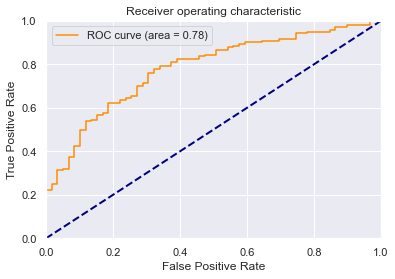

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=30, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [54]:
from numpy import average,mean
from math import ceil
params={}

params1={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'gamma':0.1,
    'subsample':0.8,
    'colsample_bytree':0.3,
    'min_child_weight':3,
    'max_depth':3,
    #'seed':1024,
    'n_jobs' : -1
}

params2={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.005,
    #'gamma':0.01,
    'subsample':0.555,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'max_depth':8,
    #'seed':1024,
    'n_jobs' : -1
}

params_avg = {    
    'n_estimators':int(ceil(average([params1['n_estimators'],params2['n_estimators']]))),
    'objective': 'binary:logistic',
    'learning_rate': average([params1['learning_rate'],params2['learning_rate']]),
    #'gamma':0.01,
    'subsample':average([params1['subsample'],params2['subsample']]),
    'colsample_bytree':average([params1['colsample_bytree'],params2['colsample_bytree']]),
    'min_child_weight':int(ceil(average([params1['min_child_weight'],params2['min_child_weight']]))),
    'max_depth':int(ceil(average([params1['max_depth'],params2['max_depth']]))),
    #'seed':1024,
    'n_jobs' : -1}

xgbclf(params1, X1_train_clean, y1_train_clean, X_test_clean, y_test_clean)

[0]	validation_0-auc:0.73385	validation_1-auc:0.63872


/Users/mingzexia/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/mingzexia/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-auc:0.88477	validation_1-auc:0.78243
[142]	validation_0-auc:0.89195	validation_1-auc:0.78014
[[ 19  40]
 [  4 137]]
              precision    recall  f1-score   support

           0       0.83      0.32      0.46        59
           1       0.77      0.97      0.86       141

    accuracy                           0.78       200
   macro avg       0.80      0.65      0.66       200
weighted avg       0.79      0.78      0.74       200



Model Final Generalization Accuracy: 0.780000


/Users/mingzexia/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/mingzexia/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


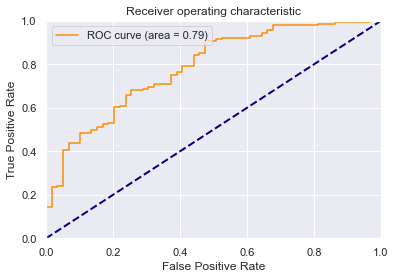

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.005, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=8, max_leaves=0, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=43, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [55]:
params={}
xgbclf(params2, X2_train_clean, y2_train_clean, X_test_clean, y_test_clean)

[0]	validation_0-auc:0.77816	validation_1-auc:0.75959


/Users/mingzexia/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/mingzexia/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-auc:0.94384	validation_1-auc:0.78699
[116]	validation_0-auc:0.95102	validation_1-auc:0.78495
[[  8  51]
 [  1 140]]
              precision    recall  f1-score   support

           0       0.89      0.14      0.24        59
           1       0.73      0.99      0.84       141

    accuracy                           0.74       200
   macro avg       0.81      0.56      0.54       200
weighted avg       0.78      0.74      0.66       200



Model Final Generalization Accuracy: 0.740000


/Users/mingzexia/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/mingzexia/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


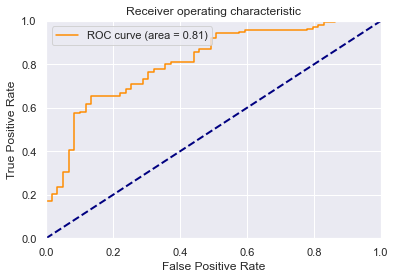

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0275, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=18, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [56]:
params={}
xgbclf(params_avg, X2_train_clean, y2_train_clean, X_test_clean, y_test_clean)